# The WebExperience Module

Well howdy amigos, hope you're enjoying the desert, and hope you enjoy hearing about how really neat apps like the ArcGIS Experience Builder are worked in the Python API. I'm sure most of you are familiar with the Experience Builder, but, in the event that you're not: it's an ArcGIS product that allows you to make interactive web applications, and there's ton of room for creativity. There are numerous different templates, layouts, widgets, and types of ArcGIS items you can incorporate.

With the level of complexity that can come with this type of application, there also comes opportunity for automation, which is what the ArcGIS API for Python does best. The Python API has a handful of modules and functions that will make your life easier when doing things such as adding, deleting, publishing, and migrating Experiences to/from portals, and we're going to take a look at some of that here. First, let's start by taking a look at the WebExperience module and its basic functions, then we'll go into a practical application of it.

## Class Details

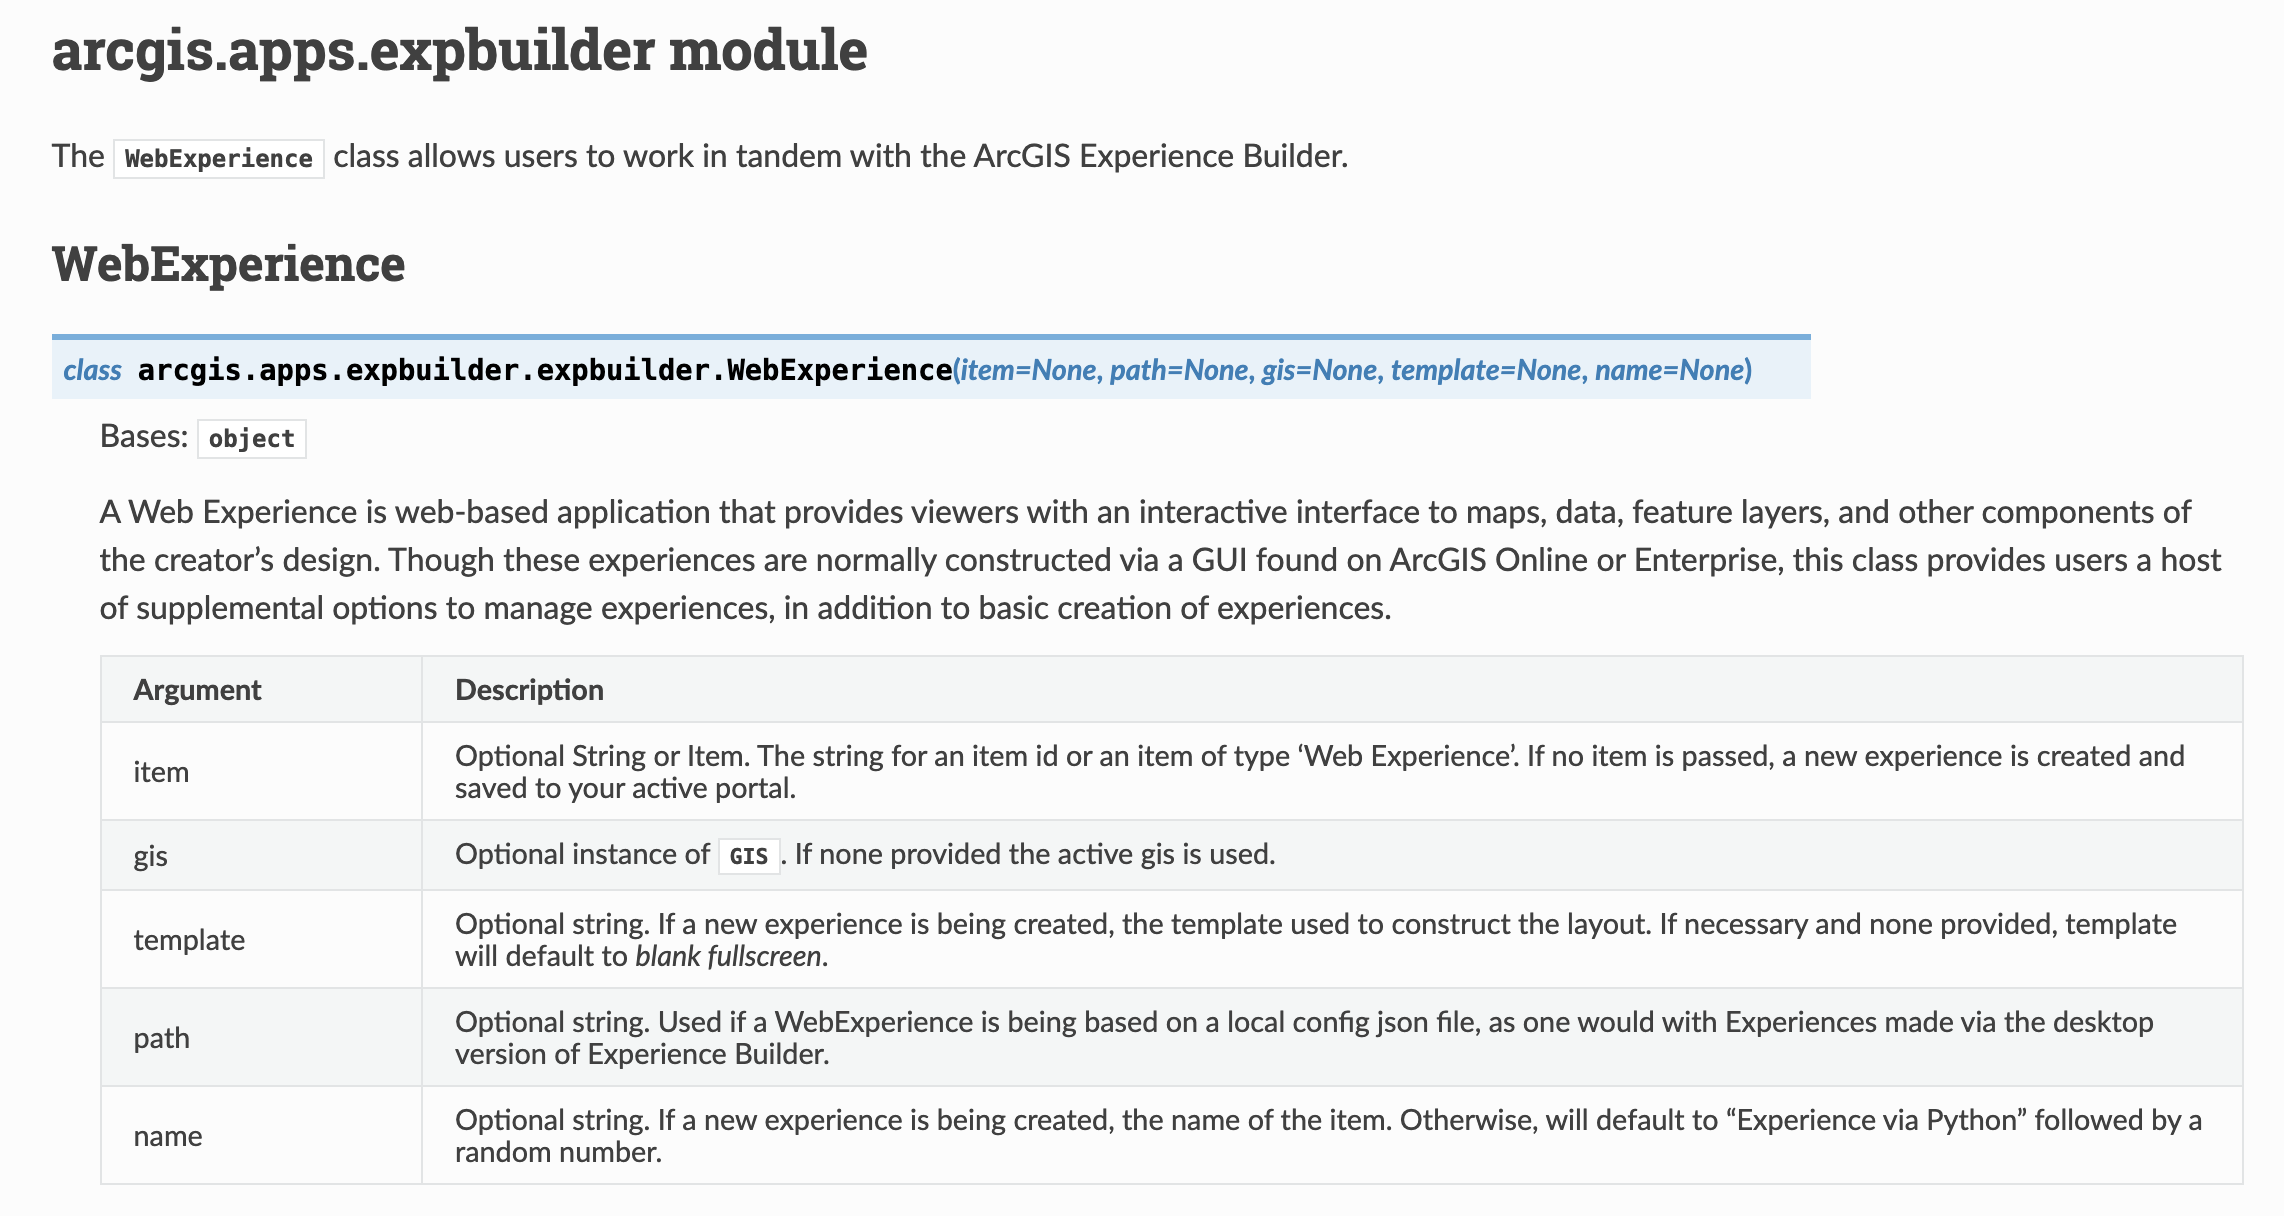

Instantiating the class is easy! 
- To work with an existing experience from a portal, simply pass in an experience `item`, or pass in the item ID of an experience from the specified or active GIS. 
- To work with a local experience made from the Desktop Experience Builder, pass in the path to the downloaded config.json file. 
- To make a new experience, just instantiate the class without passing in an item or path- when doing this, you can dictate the template and the name of the new experience.

All of these will be displayed in this notebook. We're going to start basic and create our own new experience.

In [1]:
# import the module from the apps folder, and establish a GIS connection.
from arcgis.apps.expbuilder import WebExperience
from arcgis.gis import GIS
gis = GIS(profile="your_online_profile")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Now, we'll make an experience and look at its item in arcgis.

In [2]:
new_exp = WebExperience(template = "Chronology", name = "Just a blank ol' Experience")
new_exp.item

<Item title:"Just a blank ol' Experience" type:Web Experience owner:nparavicini_geosaurus>

In addition to the `item` property, WebExperiences also have two other public facing properties- `itemid` and `datasources`.

In [3]:
new_exp.itemid

'a2ccb202fe38476aa45113e8bd057099'

In [4]:
new_exp.datasources

{}

Currently, we haven't added any data to this experience, so it shows up as empty. We'll go ahead and delete this experience, and instead show working with an existing experience.

In [5]:
new_exp.delete()

True

You may be wondering: is there any way to see a list of all the templates when creating an Experience through the Python API? Yes, there is, and we'll take a look at that now. The templates exist as an enum class in the expbuilder module; you can also pass a template object in when creating an Experience instead of the string, as we did above.

In [6]:
from arcgis.apps.expbuilder import Templates

In [7]:
# the templates also have a preview method!
Templates.MONITOR.preview()

## Content Migration Workflow

Let's get to the good stuff of what the Python API and its WebExperience class can be used for: moving Experiences around without having to recreate them from scratch. We're going to show how you can take an Experience from an isolated development environment, upload it to a staging portal, preview it, clone it to a production environment with different data, publish it, and view your published Experience, all through the ArcGIS API for Python. For those of you that attended speedgeeking yesterday, this is a very similar workflow, but with a couple extra highlights that this new class brings you.

### Working with Local Experiences

In addition to portal-based experiences, this class allows users to work with locally-based experiences created via the Developer Edition Experience Builder. One question that repeatedly came up was about establishing an easy bridge between making these experiences and distributing them to different portals, which is what our additions cater to.

You'll want to "download" your experience from your local Experience Builder app, and then figure out what the path to the `config.json` file is. Knowing this is all you need to work with it in the ArcGIS API for Python.

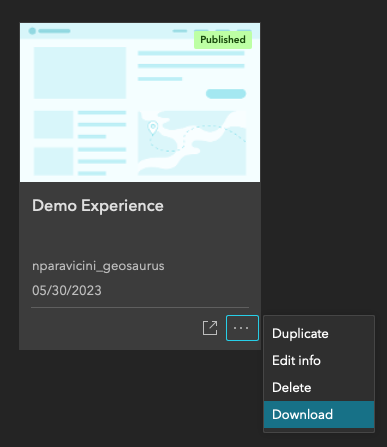

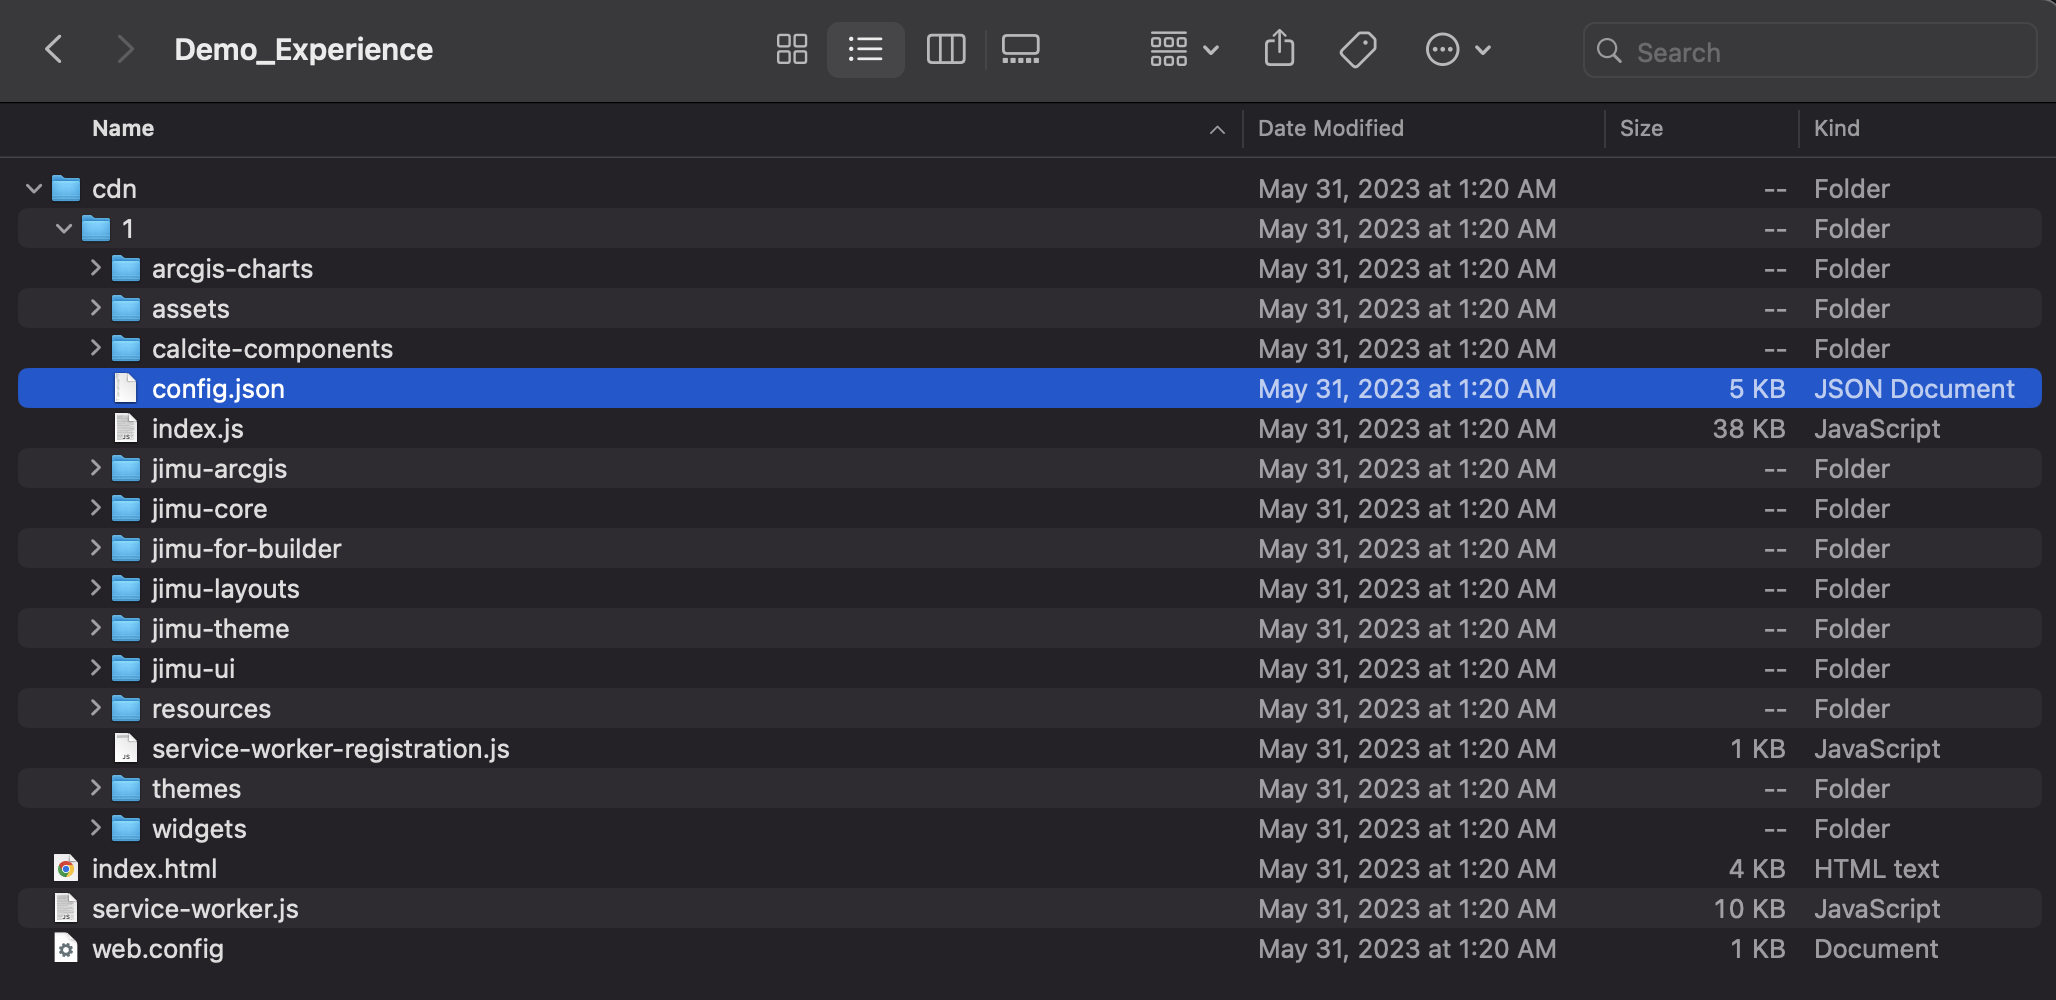

In [8]:
# pass in a path to a local config.json when instantiating experience
local_path = '/Folders/DevSummit2024/config.json'
local_exp = WebExperience(gis = gis, path = local_path)

In [9]:
local_exp.datasources

{'dataSource_1': {'id': 'dataSource_1',
  'type': 'WEB_MAP',
  'sourceLabel': 'Fish Map',
  'itemId': '307c3f461ac04ddc930811ba5f20e51f',
  'portalUrl': 'https://geosaurus.maps.arcgis.com'}}

When working with the Developer Edition Experience Builder, created Experiences won't be available in a portal, despite the local app being able to use data from a portal. So, how do we bring these local Experiences to our AGOL or Enterprise portals? We use the `WebExperience.upload()` function, which we'll take a look at here.
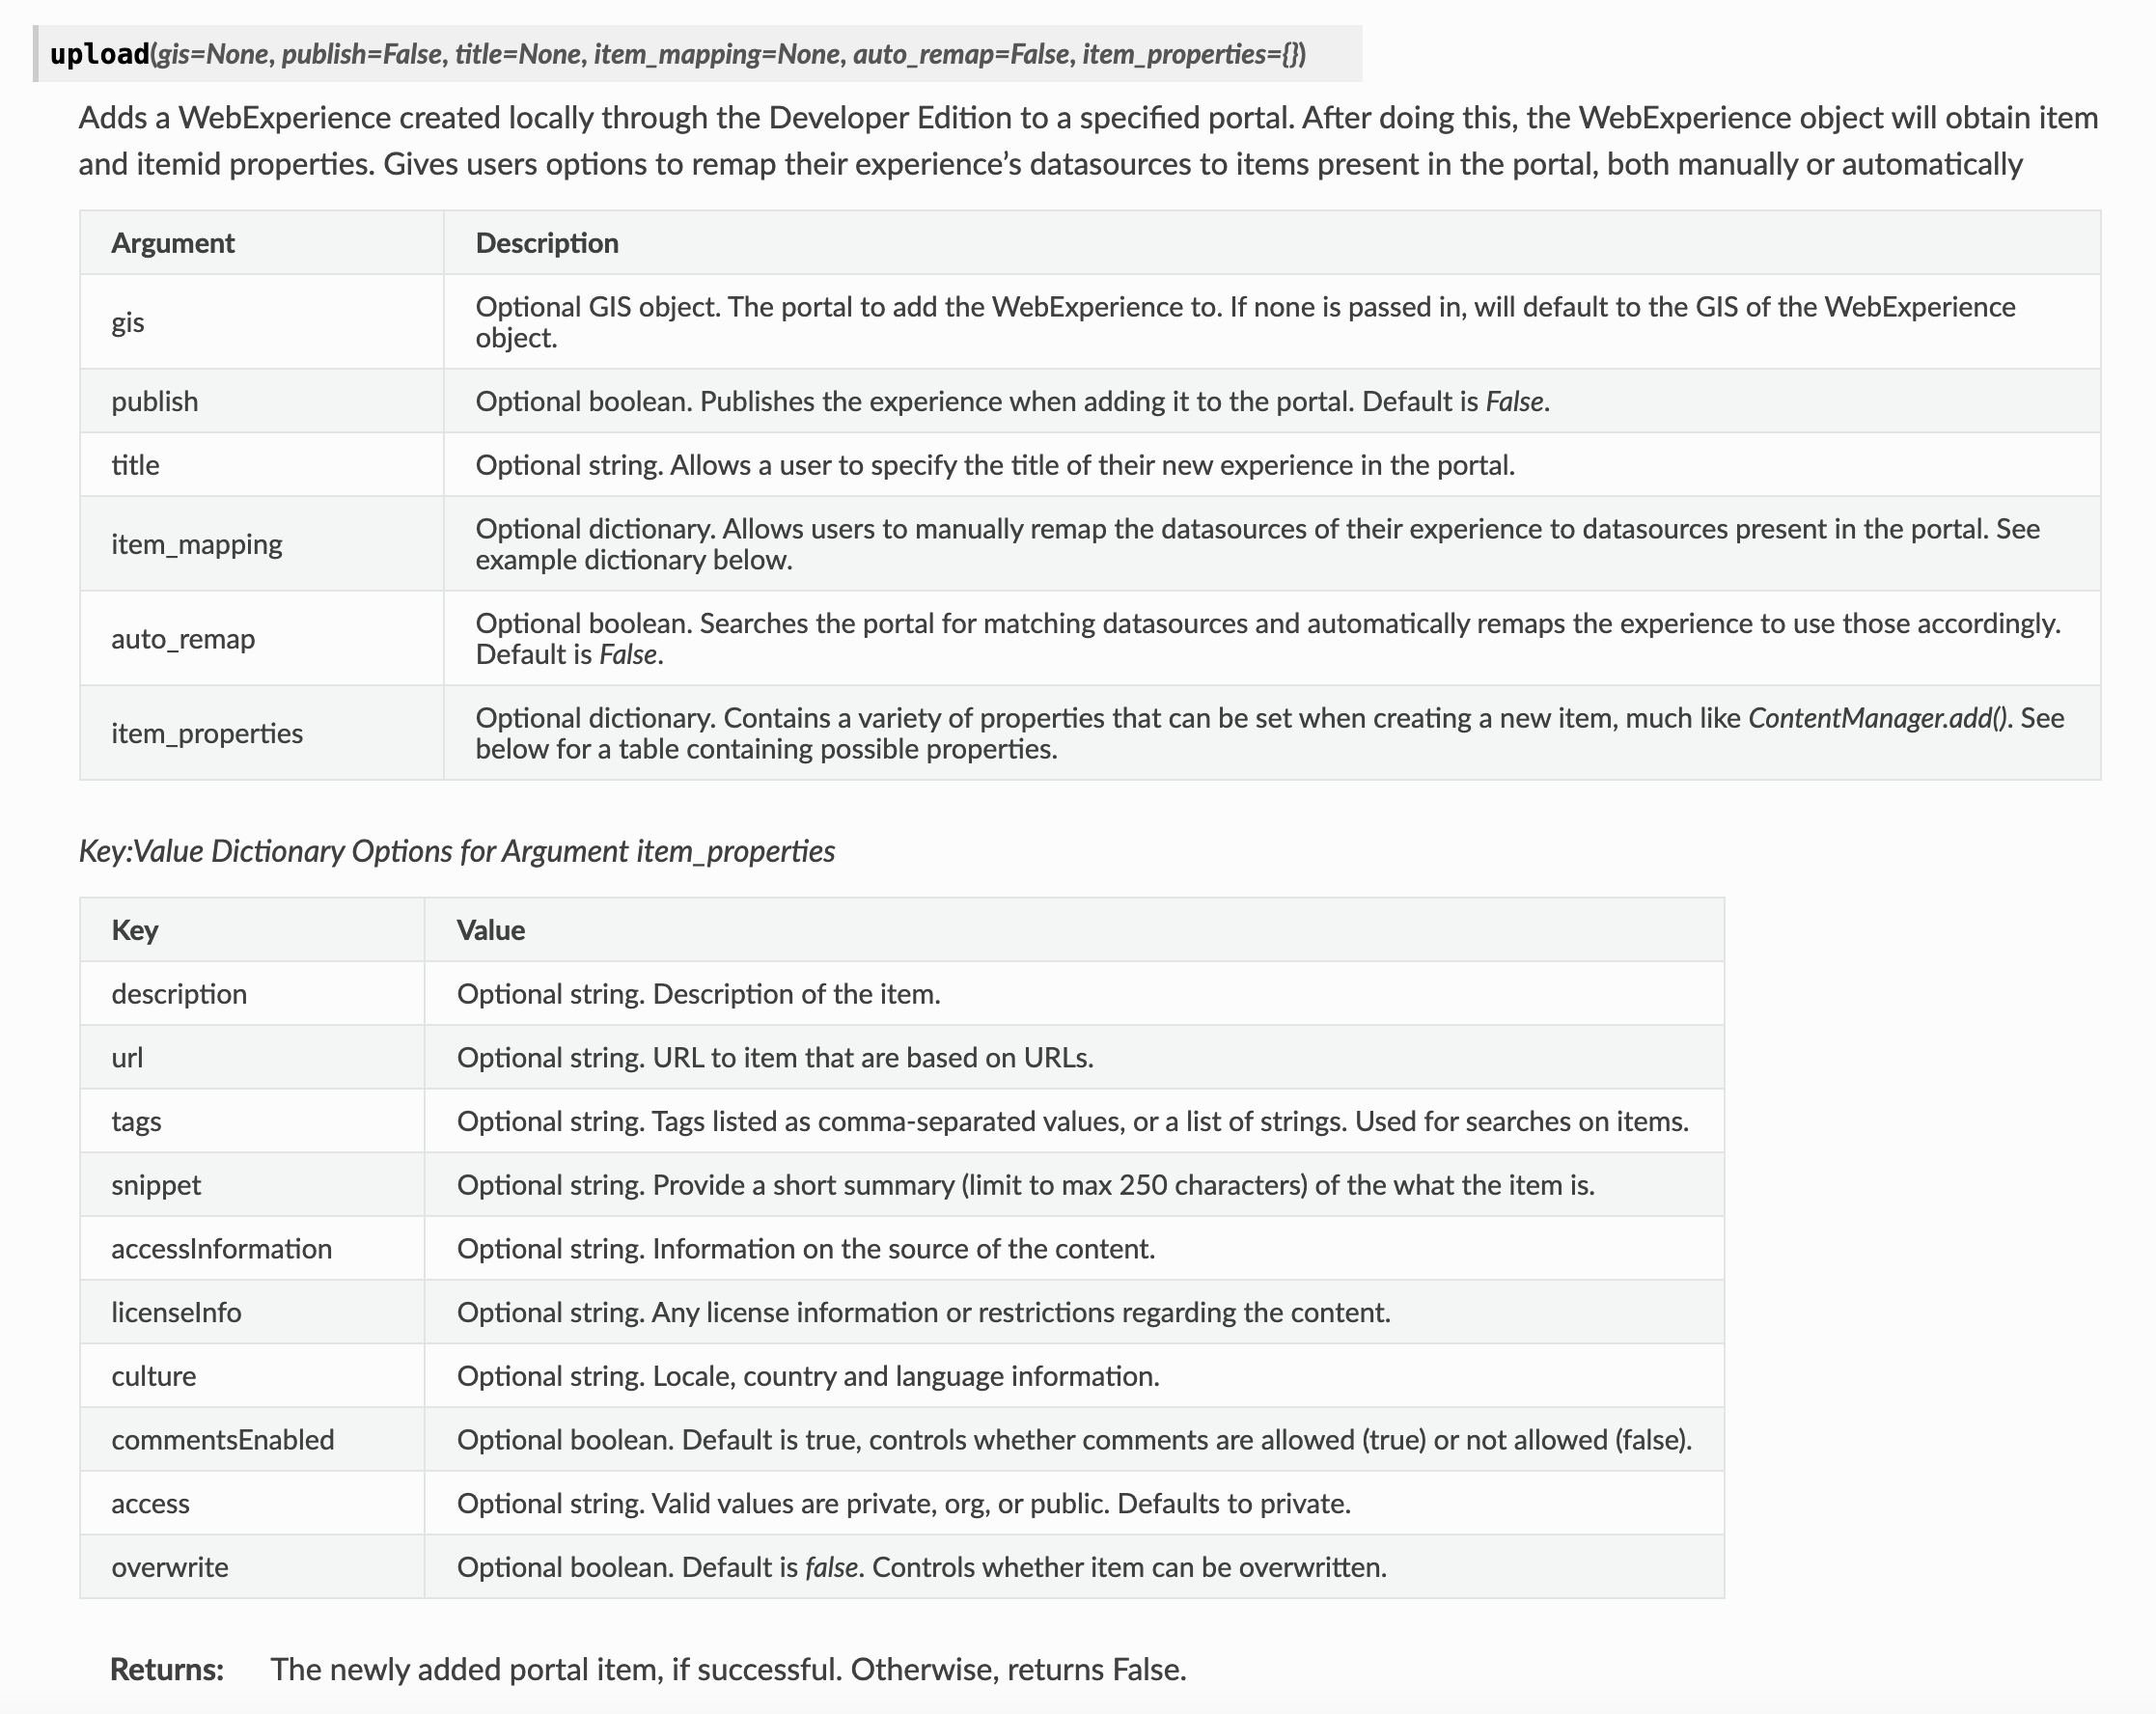

Additionally, this function gives users two options for remapping to data sources in a different portal: the `item_mapping` parameter, and the `auto_remap` parameter. These would be used in the case that you want to upload your local Experience to a portal different than the one your local app is connected to. For the sake of time and simplicity in this demo, we're just going to assume we're uploading it to the same one.

In [10]:
uploaded_exp = local_exp.upload(
    gis = gis,
    title = "Just Swimming Around and Whatnot",
)

In [11]:
uploaded_exp

<Item title:"Just Swimming Around and Whatnot" type:Web Experience owner:nparavicini_geosaurus>

`preview()` allows you to view the current Python API draft of an Experience, while `view()` allows you to see the available published version. Popups may need to be enabled in your browser in order for `preview()` to validate credentials.

In [14]:
fish_exp = WebExperience(uploaded_exp)
fish_exp.view()

Well I'll be gobsmacked! That looks good to me. Or good enough. Let's go ahead and publish it.

<Item title:"Just Swimming Around and Whatnot" type:Web Experience owner:nparavicini_geosaurus>
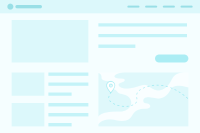

In [13]:
fish_exp.save(publish=True)
fish_exp.item

Now, the final step: say that we have a production portal that we want to move our Experience to, and it has different data items to use in the Experience. Can we easily move that over and replace the data items?

Yes! We can! Thanks to the `ContentManager`'s [clone_items()](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.clone_items) function. This function has an `item_mapping` parameter that lets a user define one-to-one mappings of data items used in the clone items. We can go ahead and construct a dictionary mapping our old map's ID to the ID of the map in the production portal that we want to use.

In [15]:
prod_gis = GIS(profile="np_pypi")
mapping = {"307c3f461ac04ddc930811ba5f20e51f" : "f422e8131f5f43ab946c23a1a6d122a2"}
migration = prod_gis.content.clone_items([uploaded_exp], item_mapping = mapping, search_existing_items=False)

<Item title:"Just Swimming Around and Whatnot" type:Web Experience owner:nparavicini_pythonapi>
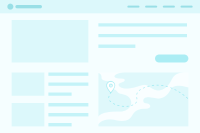

In [26]:
migration[0]

And there we have it!